In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
import os
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import optuna
from imblearn.under_sampling import RandomUnderSampler
import shap
from sklearn.base import clone
import random
import tensorflow as tf
import joblib



In [2]:
CSV_PATH = r"D:\Time_to_Event\CARDIAC_ALL_COMBINED_CLEAN_IN_ONLY.csv"
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
print(df[["TOTHLOS"]].head())

Shape: (212812, 31)
   TOTHLOS
0        3
1        5
2        1
3        2
4        4


In [3]:
def categorize_los_binary(los):
    if los <= 5:
        return "Short_Medium"  
    else:
        return "Long"          


df["TOTHLOS"] = df["TOTHLOS"].apply(categorize_los_binary)

mapping = {"Short_Medium": 0, "Long": 1}
df["TOTHLOS"] = df["TOTHLOS"].map(mapping)

print("\nClass mapping counts (0 = Short+Medium, 1 = Long):")
print(df["TOTHLOS"].value_counts().sort_index())


Class mapping counts (0 = Short+Medium, 1 = Long):
TOTHLOS
0    172050
1     40762
Name: count, dtype: int64


In [4]:
# Sex in each class
target_col = "TOTHLOS"
sex_col = "SEX"

counts = df.groupby(target_col)[sex_col].value_counts().rename("count")
perc   = df.groupby(target_col)[sex_col].value_counts(normalize=True).mul(100).rename("percentage")

sex_table = (
    pd.concat([counts, perc], axis=1)
      .reset_index()
)

sex_table



,TOTHLOS,SEX,count,percentage
0,0,0,102458,59.551293
1,0,1,69544,40.420808
2,0,2,48,0.027899
3,1,0,25921,63.591090
4,1,1,14828,36.377018
5,1,2,13,0.031892


In [5]:
# age in each class
counts = df.groupby("TOTHLOS")["Age"].value_counts().rename("count")
perc   = df.groupby("TOTHLOS")["Age"].value_counts(normalize=True).mul(100).rename("percentage")

age_table = pd.concat([counts, perc], axis=1).reset_index()
age_table



,TOTHLOS,Age,count,percentage
0,0,3,83249,48.386516
1,0,2,47106,27.379250
2,0,4,29746,17.289160
3,0,1,11949,6.945074
4,1,4,17633,43.258427
5,1,3,15892,38.987292
6,1,2,5747,14.098916
7,1,1,1490,3.655365


In [6]:
sex_count_by_age = (
    df
    .groupby(["TOTHLOS", "Age", "SEX"])
    .size()
    .unstack(fill_value=0)   
    .reset_index()
)

sex_count_by_age


SEX,TOTHLOS,Age,0,1,2
0,0,1,5609,6338,2
1,0,2,26205,20889,12
2,0,3,50485,32740,24
3,0,4,20159,9577,10
4,1,1,736,752,2
5,1,2,3291,2453,3
6,1,3,9811,6076,5
7,1,4,12083,5547,3


In [7]:
sex_pct_by_age = sex_count_by_age.copy()

total = sex_pct_by_age[0] + sex_pct_by_age[1]

sex_pct_by_age["Female_%"] = sex_pct_by_age[0] / total * 100
sex_pct_by_age["Male_%"]   = sex_pct_by_age[1] / total * 100

sex_pct_by_age[
    ["TOTHLOS", "Age", "Female_%", "Male_%"]
]


SEX,TOTHLOS,Age,Female_%,Male_%
0,0,1,46.949025,53.050975
1,0,2,55.644031,44.355969
2,0,3,60.660859,39.339141
3,0,4,67.793247,32.206753
4,1,1,49.462366,50.537634
5,1,2,57.294568,42.705432
6,1,3,61.754894,38.245106
7,1,4,68.536585,31.463415


In [8]:
import matplotlib.pyplot as plt

plot_df = df[['TOTHLOS', 'Age']]


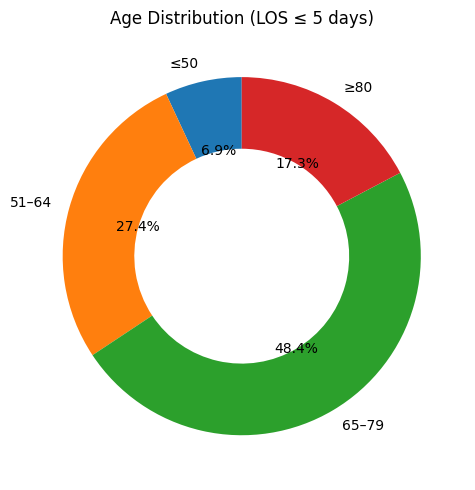

In [9]:
age_counts_0 = (
    plot_df[plot_df['TOTHLOS'] == 0]['Age']
    .value_counts()
    .sort_index()
)

labels = ['≤50', '51–64', '65–79', '≥80']

plt.figure(figsize=(5,5))
plt.pie(
    age_counts_0,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width':0.4}
)
plt.title('Age Distribution (LOS ≤ 5 days)')
plt.tight_layout()
plt.show()


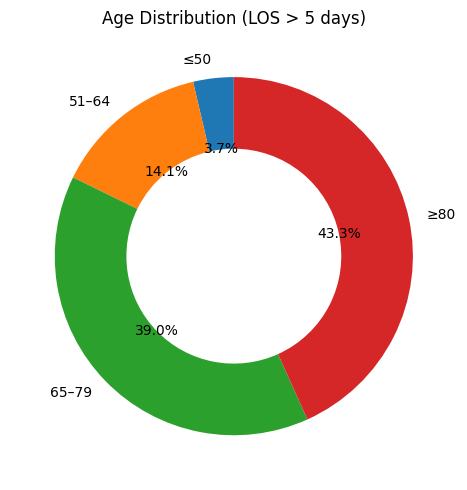

In [10]:
age_counts_1 = (
    plot_df[plot_df['TOTHLOS'] == 1]['Age']
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(5,5))
plt.pie(
    age_counts_1,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width':0.4}
)
plt.title('Age Distribution (LOS > 5 days)')
plt.tight_layout()
plt.show()


In [11]:
df = df.drop(columns= ["INOUT", "OTHDVT", "PULEMBOL"])
print (df.columns)

Index(['SEX', 'RACE_NEW', 'Age', 'ASACLAS', 'CPT', 'ANESTHES', 'SMOKE',
       'FNSTATUS2', 'HXCOPD', 'ASCITES', 'HXCHF', 'HYPERMED', 'DIALYSIS',
       'DISCANCR', 'STEROID', 'BLEEDDIS', 'TRANSFUS', 'PRSODM', 'PRCREAT',
       'PRWBC', 'PRHCT', 'PRPTT', 'DIABETES', 'TOTHLOS', 'CASETYPE',
       'OXYGEN_SUPPORT', 'Year', 'BMI'],
      dtype='object')


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212812 entries, 0 to 212811
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEX             212812 non-null  int64  
 1   RACE_NEW        212812 non-null  int64  
 2   Age             212812 non-null  int64  
 3   ASACLAS         212812 non-null  float64
 4   CPT             212812 non-null  int64  
 5   ANESTHES        212812 non-null  float64
 6   SMOKE           212812 non-null  int64  
 7   FNSTATUS2       212812 non-null  float64
 8   HXCOPD          212812 non-null  int64  
 9   ASCITES         212812 non-null  int64  
 10  HXCHF           212812 non-null  int64  
 11  HYPERMED        212812 non-null  int64  
 12  DIALYSIS        212812 non-null  int64  
 13  DISCANCR        212812 non-null  int64  
 14  STEROID         212812 non-null  int64  
 15  BLEEDDIS        212812 non-null  int64  
 16  TRANSFUS        212812 non-null  int64  
 17  PRSODM    

In [13]:
print(df.shape)

(212812, 28)


In [14]:
import os, joblib
from sklearn.base import clone

SAVE_DIR = "models_saved"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_joblib(obj, name):
    path = os.path.join(SAVE_DIR, name)
    joblib.dump(obj, path)
    print("Saved:", path)


In [15]:
X = df.drop(columns=["TOTHLOS"])
y = df["TOTHLOS"]

In [16]:
save_joblib(list(X.columns), "feature_names.pkl")
save_joblib({"cutoff": 5, "mapping": {"Short_Medium": 0, "Long": 1}}, "label_spec.pkl")
save_joblib(["INOUT", "OTHDVT", "PULEMBOL"], "dropped_cols.pkl")


Saved: models_saved\feature_names.pkl
Saved: models_saved\label_spec.pkl
Saved: models_saved\dropped_cols.pkl


In [17]:
def evaluate_model_binary_oof(model, X, y, cv):
    all_y_true  = []
    all_y_pred  = []
    all_y_proba = []
    all_fold_id = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model_fold = clone(model)
        model_fold.fit(X_train, y_train)

        y_pred = model_fold.predict(X_val)
        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))
        all_fold_id.extend([fold]*len(val_idx))

        if hasattr(model_fold, "predict_proba"):
            y_proba = model_fold.predict_proba(X_val)[:, 1]
        else:
            raise ValueError("Model has no predict_proba; use a probabilistic model or calibrate it.")
        all_y_proba.extend(list(y_proba))

    all_y_true  = np.array(all_y_true)
    all_y_pred  = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)
    all_fold_id = np.array(all_fold_id)

    cm = confusion_matrix(all_y_true, all_y_pred, labels=[0, 1])
    results = {
        "accuracy_overall": accuracy_score(all_y_true, all_y_pred),
        "precision_macro": precision_score(all_y_true, all_y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(all_y_true, all_y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(all_y_true, all_y_pred, average="macro", zero_division=0),
        "roc_auc": roc_auc_score(all_y_true, all_y_proba),
        "confusion_matrix": cm,
        
        "y_true_oof": all_y_true,
        "y_pred_oof": all_y_pred,
        "y_proba_oof": all_y_proba,
        "fold_id_oof": all_fold_id
    }
    return results


In [18]:
def bootstrap_ci(y_true, y_proba, y_pred=None, n_boot=2000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    idx = np.arange(n)

    aucs, f1s, accs = [], [], []
    for _ in range(n_boot):
        b = rng.choice(idx, size=n, replace=True)
        yt = y_true[b]
        yp = y_proba[b]

        if len(np.unique(yt)) < 2:
            continue
        aucs.append(roc_auc_score(yt, yp))

        if y_pred is not None:
            yhat = y_pred[b]
            f1s.append(f1_score(yt, yhat, average="macro", zero_division=0))
            accs.append(accuracy_score(yt, yhat))

    def summarize(arr):
        arr = np.array(arr)
        lo = np.quantile(arr, alpha/2)
        hi = np.quantile(arr, 1-alpha/2)
        return float(arr.mean()), float(lo), float(hi)

    out = {"auc": summarize(aucs)}
    if y_pred is not None:
        out["f1_macro"] = summarize(f1s)
        out["accuracy"] = summarize(accs)
    return out


In [19]:
RANDOM_STATE = 42

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

### XGBoost

In [20]:
xgb_clf = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary:logistic",  
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss"         
)

xgb_results = evaluate_model_binary_oof(xgb_clf, X, y, cv)

print("=== XGBoost (2-class) ===")
for k, v in xgb_results.items():
    print(f"{k}:\n{v}\n")


=== XGBoost (2-class) ===
accuracy_overall:
0.8420812736123903

precision_macro:
0.7532290018360539

recall_macro:
0.6784190501090808

f1_macro:
0.7033782177031815

roc_auc:
0.8463666112888903

confusion_matrix:
[[162365   9685]
 [ 23922  16840]]

y_true_oof:
[0 0 0 ... 0 1 0]

y_pred_oof:
[0 0 0 ... 0 0 0]

y_proba_oof:
[0.26226947 0.04862985 0.0520122  ... 0.02989456 0.40753415 0.18386334]

fold_id_oof:
[1 1 1 ... 5 5 5]



In [21]:
xgb_ci = bootstrap_ci(
    y_true=xgb_results["y_true_oof"],
    y_proba=xgb_results["y_proba_oof"],
    y_pred=xgb_results["y_pred_oof"],
    n_boot=2000,
    alpha=0.05
)

print("=== XGBoost_scale_pos_weight 95% Confidence Intervals (OOF) ===")
for k, (mean, lo, hi) in xgb_ci.items():
    print(f"{k}: {mean:.3f} (95% CI {lo:.3f} – {hi:.3f})")

=== XGBoost_scale_pos_weight 95% Confidence Intervals (OOF) ===
auc: 0.846 (95% CI 0.844 – 0.848)
f1_macro: 0.703 (95% CI 0.701 – 0.706)
accuracy: 0.842 (95% CI 0.841 – 0.844)


### Random Forest

In [22]:
rf_clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_results = evaluate_model_binary_oof(rf_clf, X, y, cv)

print("=== Random Forest (2-class) ===")
for k, v in rf_results.items():
    print(f"{k}:\n{v}\n")

=== Random Forest (2-class) ===
accuracy_overall:
0.8413012424111422

precision_macro:
0.7526405813111992

recall_macro:
0.6735747815506635

f1_macro:
0.6991237201561533

roc_auc:
0.8422587185063226

confusion_matrix:
[[162665   9385]
 [ 24388  16374]]

y_true_oof:
[0 0 0 ... 0 1 0]

y_pred_oof:
[0 0 0 ... 0 0 0]

y_proba_oof:
[0.35296224 0.12108988 0.04647691 ... 0.02143149 0.41675512 0.24829891]

fold_id_oof:
[1 1 1 ... 5 5 5]



In [23]:
rf_ci = bootstrap_ci(
    y_true=rf_results["y_true_oof"],
    y_proba=rf_results["y_proba_oof"],
    y_pred=rf_results["y_pred_oof"],
    n_boot=2000,
    alpha=0.05
)

print("=== Random Forest 95% Confidence Intervals (OOF) ===")
for k, (mean, lo, hi) in rf_ci.items():
    print(f"{k}: {mean:.3f} (95% CI {lo:.3f} – {hi:.3f})")

=== Random Forest 95% Confidence Intervals (OOF) ===
auc: 0.842 (95% CI 0.840 – 0.844)
f1_macro: 0.699 (95% CI 0.697 – 0.702)
accuracy: 0.841 (95% CI 0.840 – 0.843)


In [24]:
rf_final = clone(rf_clf)
rf_final.fit(X, y)             
save_joblib(rf_final, "rf_final.pkl")


Saved: models_saved\rf_final.pkl


### MLP Neural Network

In [25]:
mlp_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        learning_rate_init=0.001,
        max_iter=400,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=30,
        random_state=RANDOM_STATE,
        verbose=False
    ))
])

mlp_results = evaluate_model_binary_oof(mlp_clf, X, y, cv)

print("=== MLPClassifier (2-class) ===")
for k, v in mlp_results.items():
    print(f"{k}:\n{v}\n")

=== MLPClassifier (2-class) ===
accuracy_overall:
0.83914440914986

precision_macro:
0.7462416429001872

recall_macro:
0.6745996360155658

f1_macro:
0.6985781433050139

roc_auc:
0.8411198604252461

confusion_matrix:
[[161954  10096]
 [ 24136  16626]]

y_true_oof:
[0 0 0 ... 0 1 0]

y_pred_oof:
[0 0 0 ... 0 0 0]

y_proba_oof:
[0.29449615 0.04123473 0.05822394 ... 0.05494302 0.46560654 0.22049733]

fold_id_oof:
[1 1 1 ... 5 5 5]



In [26]:
mlp_ci = bootstrap_ci(
    y_true=mlp_results["y_true_oof"],
    y_proba=mlp_results["y_proba_oof"],
    y_pred=mlp_results["y_pred_oof"],
    n_boot=2000,
    alpha=0.05
)

print("=== MLP 95% Confidence Intervals (OOF) ===")
for k, (mean, lo, hi) in mlp_ci.items():
    print(f"{k}: {mean:.3f} (95% CI {lo:.3f} – {hi:.3f})")

=== MLP 95% Confidence Intervals (OOF) ===
auc: 0.841 (95% CI 0.839 – 0.843)
f1_macro: 0.699 (95% CI 0.696 – 0.701)
accuracy: 0.839 (95% CI 0.838 – 0.841)


In [27]:
mlp_final = clone(mlp_clf)
mlp_final.fit(X, y)
save_joblib(mlp_final, "mlp_final_pipeline.pkl")


Saved: models_saved\mlp_final_pipeline.pkl


### DNN with CI

In [28]:
def build_dnn_binary(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,))

    x = layers.BatchNormalization()(inputs)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="DNN_LOS_2class")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [29]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


In [30]:
def evaluate_keras_model_binary(X, y, cv, epochs=50, batch_size=512, threshold=0.5, base_seed=42):
    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    X_np = X.to_numpy()
    y_np = y.to_numpy()

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_np, y_np), 1):
        print(f"\n=== Keras DNN - Fold {fold} ===")

        set_seed(base_seed + fold)

        X_train, X_val = X_np[train_idx], X_np[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        X_val_sc   = scaler.transform(X_val)

        model = build_dnn_binary(input_dim=X_train_sc.shape[1])

        early_stop = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )

        model.fit(
            X_train_sc, y_train,
            validation_data=(X_val_sc, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[early_stop]
        )

        y_proba = model.predict(X_val_sc, verbose=0).flatten()
        y_pred  = (y_proba >= threshold).astype(int)

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)

    all_y_true  = np.array(all_y_true)
    all_y_pred  = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    cm = confusion_matrix(all_y_true, all_y_pred, labels=[0, 1])
    acc             = accuracy_score(all_y_true, all_y_pred)
    precision_macro = precision_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    recall_macro    = recall_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    f1_macro        = f1_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    roc_auc         = roc_auc_score(all_y_true, all_y_proba)

    results = {
        "accuracy_overall": acc,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "roc_auc": roc_auc,
        "confusion_matrix": cm,

        "y_true_oof": all_y_true,
        "y_pred_oof": all_y_pred,
        "y_proba_oof": all_y_proba,
    }
    return results


In [31]:
dnn_results = evaluate_keras_model_binary(X, y, cv, base_seed=42)


=== Keras DNN - Fold 1 ===

=== Keras DNN - Fold 2 ===

=== Keras DNN - Fold 3 ===

=== Keras DNN - Fold 4 ===

=== Keras DNN - Fold 5 ===


In [32]:
print("\n=== Keras DNN (2-class) METRICS (OOF) ===")
for k, v in dnn_results.items():
    if k.endswith("_oof"):
        continue
    print(f"{k}: {v}")

print("\nOOF lengths:",
      len(dnn_results["y_true_oof"]),
      len(dnn_results["y_pred_oof"]),
      len(dnn_results["y_proba_oof"]))

dnn_ci = bootstrap_ci(
    y_true=dnn_results["y_true_oof"],
    y_proba=dnn_results["y_proba_oof"],
    y_pred=dnn_results["y_pred_oof"],
    n_boot=2000,
    alpha=0.05
)

print("\n=== Keras DNN 95% Confidence Intervals (OOF) ===")
for k, (mean, lo, hi) in dnn_ci.items():
    print(f"{k}: {mean:.3f} (95% CI {lo:.3f} – {hi:.3f})")



=== Keras DNN (2-class) METRICS (OOF) ===
accuracy_overall: 0.8408454410465576
precision_macro: 0.7481617352613401
recall_macro: 0.6845063998141422
f1_macro: 0.7071261522818004
roc_auc: 0.844383602371909
confusion_matrix: [[161370  10680]
 [ 23190  17572]]

OOF lengths: 212812 212812 212812

=== Keras DNN 95% Confidence Intervals (OOF) ===
auc: 0.844 (95% CI 0.842 – 0.846)
f1_macro: 0.707 (95% CI 0.704 – 0.710)
accuracy: 0.841 (95% CI 0.839 – 0.842)


In [33]:
dnn_scaler = StandardScaler()
X_sc = dnn_scaler.fit_transform(X)

dnn_final = build_dnn_binary(input_dim=X_sc.shape[1])

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

dnn_final.fit(
    X_sc, y,
    validation_split=0.15,
    epochs=50,
    batch_size=512,
    verbose=0,
    callbacks=[early_stop]
)

save_joblib(dnn_scaler, "dnn_scaler.pkl")
dnn_final.save(os.path.join(SAVE_DIR, "dnn_final.keras"))
print("Saved:", os.path.join(SAVE_DIR, "dnn_final.keras"))


Saved: models_saved\dnn_scaler.pkl
Saved: models_saved\dnn_final.keras


### XGBoost Classifier + Optuna

### Optuna on AUC

In [34]:
def tune_xgb_optuna_auc(X, y, cv, n_trials=20, random_state=42, use_early_stopping=False):
    """
    Returns:
      best_params, best_auc, study
    """
    sampler = optuna.samplers.TPESampler(seed=random_state)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 800),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),

            "objective": "binary:logistic",
            "tree_method": "hist",
            "eval_metric": "auc",
            "random_state": random_state,
            "n_jobs": -1,
        }

        auc_scores = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = XGBClassifier(**params)

            if use_early_stopping:
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False,
                )
            else:
                model.fit(X_train, y_train)

            y_val_proba = model.predict_proba(X_val)[:, 1]
            fold_auc = roc_auc_score(y_val, y_val_proba)
            auc_scores.append(fold_auc)

        return -float(np.mean(auc_scores))

    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params.copy()

    best_params.update({
        "objective": "binary:logistic",
        "tree_method": "hist",
        "eval_metric": "auc",
        "random_state": random_state,
        "n_jobs": -1,
    })

    best_auc = -study.best_value
    return best_params, best_auc, study


In [35]:
best_params, best_auc, study = tune_xgb_optuna_auc(
    X, y, cv,
    n_trials=20,
    random_state=42,
    use_early_stopping=False
)

print("Best CV AUC (Optuna):", best_auc)
print("Best params:", best_params)


[I 2025-12-27 11:46:55,748] A new study created in memory with name: no-name-14f29153-bd2c-4a9f-bb50-b80731c7ca35
[I 2025-12-27 11:47:03,793] Trial 0 finished with value: -0.8450271404530645 and parameters: {'n_estimators': 487, 'max_depth': 10, 'min_child_weight': 7.587945476302646, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5808361216819946, 'reg_alpha': 8.661761457749352, 'learning_rate': 0.12421185223120967}. Best is trial 0 with value: -0.8450271404530645.
[I 2025-12-27 11:47:10,293] Trial 1 finished with value: -0.845657919511944 and parameters: {'n_estimators': 654, 'max_depth': 3, 'min_child_weight': 9.72918866945795, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'reg_lambda': 1.8340450985343382, 'reg_alpha': 3.0424224295953772, 'learning_rate': 0.10970372201012518}. Best is trial 1 with value: -0.845657919511944.
[I 2025-12-27 11:47:18,544] Trial 2

Best CV AUC (Optuna): 0.8476134637616097
Best params: {'n_estimators': 699, 'max_depth': 9, 'min_child_weight': 8.445930851432848, 'subsample': 0.6873064153189612, 'colsample_bytree': 0.9643603125729512, 'gamma': 3.2315598815608118, 'reg_lambda': 5.436273260751044, 'reg_alpha': 1.6958152938775188, 'learning_rate': 0.018237848225438114, 'objective': 'binary:logistic', 'tree_method': 'hist', 'eval_metric': 'auc', 'random_state': 42, 'n_jobs': -1}


In [36]:
xgb_opt_clf = XGBClassifier(**best_params)

xgb_opt_results = evaluate_model_binary_oof(xgb_opt_clf, X, y, cv)

print("\n=== XGBoost + Optuna (2-class) METRICS (OOF) ===")
for k, v in xgb_opt_results.items():
    if k.endswith("_oof"):
        continue
    print(f"{k}: {v}")



=== XGBoost + Optuna (2-class) METRICS (OOF) ===
accuracy_overall: 0.8432325244817022
precision_macro: 0.7557355660141558
recall_macro: 0.6806567641443577
f1_macro: 0.7058281821201392
roc_auc: 0.8475897678004716
confusion_matrix: [[162447   9603]
 [ 23759  17003]]


In [37]:
xgb_opt_ci = bootstrap_ci(
    y_true=xgb_opt_results["y_true_oof"],
    y_proba=xgb_opt_results["y_proba_oof"],
    y_pred=xgb_opt_results["y_pred_oof"],
    n_boot=2000,    
    alpha=0.05,
    seed=42
)

print("\n=== XGBoost + Optuna 95% Confidence Intervals (OOF) ===")
for k, (mean, lo, hi) in xgb_opt_ci.items():
    print(f"{k}: {mean:.3f} (95% CI {lo:.3f} – {hi:.3f})")



=== XGBoost + Optuna 95% Confidence Intervals (OOF) ===
auc: 0.848 (95% CI 0.846 – 0.850)
f1_macro: 0.706 (95% CI 0.703 – 0.709)
accuracy: 0.843 (95% CI 0.842 – 0.845)


In [38]:
xgb_opt_final = XGBClassifier(**best_params)
xgb_opt_final.fit(X, y)

joblib.dump(xgb_opt_final, "xgb_optuna_final.pkl")
joblib.dump(best_params, "xgb_optuna_best_params.pkl")

print("Saved: xgb_optuna_final.pkl")
print("Saved: xgb_optuna_best_params.pkl")


Saved: xgb_optuna_final.pkl
Saved: xgb_optuna_best_params.pkl


In [39]:
xgb_final = XGBClassifier(**best_params)
xgb_final.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9643603125729512, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=3.2315598815608118, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.018237848225438114,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=8.445930851432848, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=699,
              n_jobs=-1, num_parallel_tree=None, ...)

PermutationExplainer explainer: 501it [00:40, 10.65it/s]                         


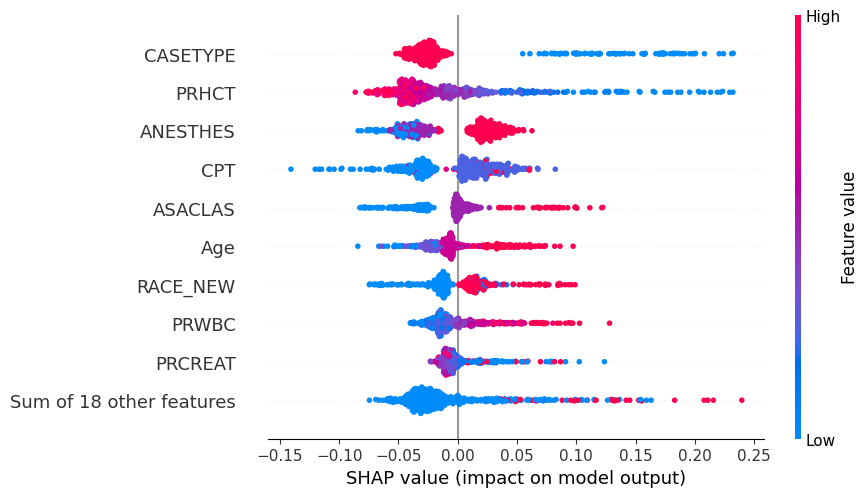

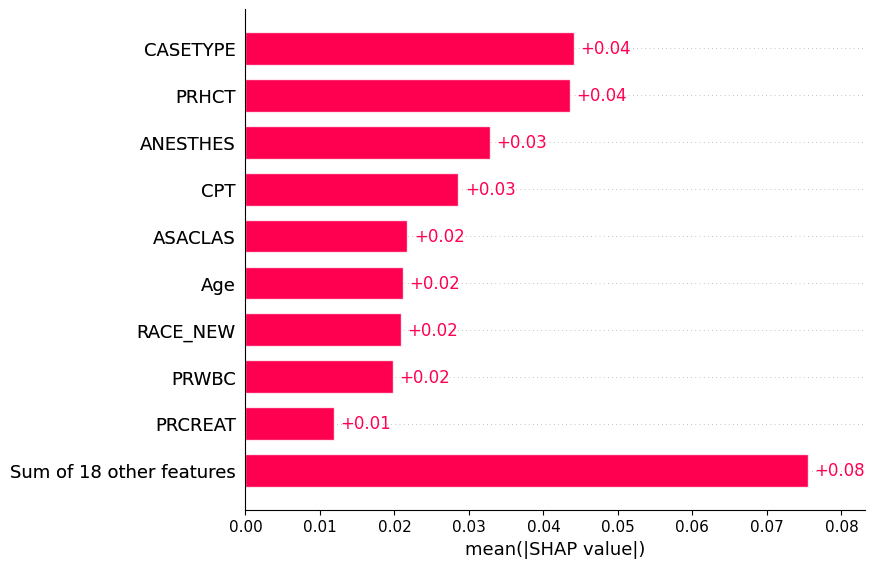

In [40]:

X_bg = X.sample(n=min(1500, len(X)), random_state=RANDOM_STATE)
X_explain = X.sample(n=min(500, len(X)), random_state=RANDOM_STATE)

model_fn = lambda data: xgb_final.predict_proba(data)[:, 1]

explainer = shap.Explainer(model_fn, X_bg)

shap_values = explainer(X_explain)

shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)



### LIME

In [41]:
from lime.lime_tabular import LimeTabularExplainer

def predict_proba_wrapper(data):
    return xgb_final.predict_proba(data)

explainer = LimeTabularExplainer(
    training_data=X.values,              
    feature_names=X.columns.tolist(),
    class_names=["Class 0", "Class 1"],   
    mode="classification",
    discretize_continuous=True
)

i = 0
x_row = X.iloc[i].values


exp = explainer.explain_instance(
    data_row=x_row,
    predict_fn=predict_proba_wrapper,
    num_features=10,
    labels=(1,)
)

exp.show_in_notebook(show_table=True)

fig = exp.as_pyplot_figure(label=1)
fig.tight_layout()
fig.savefig("lime_case1.png", dpi=300, bbox_inches="tight")
plt.close(fig)

In [42]:
all_results = {
    "XGB": xgb_results,
    "XGBoost_Optuna": xgb_opt_results,
    "RandomForest": rf_results,
    "MLP": mlp_results,
    "KerasDNN": dnn_results,
}

for name, res in all_results.items():
    ci = bootstrap_ci(
        y_true=res["y_true_oof"],
        y_proba=res["y_proba_oof"],
        y_pred=res["y_pred_oof"],
        n_boot=2000,
        alpha=0.05
    )
    print(f"\n=== {name} 95% Confidence Intervals (OOF) ===")
    for k, (mean, lo, hi) in ci.items():
        print(f"{k}: {mean:.3f} (95% CI {lo:.3f} – {hi:.3f})")



=== XGB 95% Confidence Intervals (OOF) ===
auc: 0.846 (95% CI 0.844 – 0.848)
f1_macro: 0.703 (95% CI 0.701 – 0.706)
accuracy: 0.842 (95% CI 0.841 – 0.844)

=== XGBoost_Optuna 95% Confidence Intervals (OOF) ===
auc: 0.848 (95% CI 0.846 – 0.850)
f1_macro: 0.706 (95% CI 0.703 – 0.709)
accuracy: 0.843 (95% CI 0.842 – 0.845)

=== RandomForest 95% Confidence Intervals (OOF) ===
auc: 0.842 (95% CI 0.840 – 0.844)
f1_macro: 0.699 (95% CI 0.697 – 0.702)
accuracy: 0.841 (95% CI 0.840 – 0.843)

=== MLP 95% Confidence Intervals (OOF) ===
auc: 0.841 (95% CI 0.839 – 0.843)
f1_macro: 0.699 (95% CI 0.696 – 0.701)
accuracy: 0.839 (95% CI 0.838 – 0.841)

=== KerasDNN 95% Confidence Intervals (OOF) ===
auc: 0.844 (95% CI 0.842 – 0.846)
f1_macro: 0.707 (95% CI 0.704 – 0.710)
accuracy: 0.841 (95% CI 0.839 – 0.842)


In [ ]:
from scipy import stats

def _compute_midrank(x: np.ndarray) -> np.ndarray:
    """Compute midranks used by DeLong's algorithm."""
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)

    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1) + 1
        i = j

    T2 = np.empty(N, dtype=float)
    T2[J] = T
    return T2


def _fast_delong(preds_sorted_T: np.ndarray, m: int):
    """
    Fast DeLong implementation.
    preds_sorted_T shape: (n_classifiers, n_examples) with positives first.
    m: number of positive examples.
    """
    n = preds_sorted_T.shape[1] - m
    pos = preds_sorted_T[:, :m]
    neg = preds_sorted_T[:, m:]
    k = preds_sorted_T.shape[0]

    tx = np.zeros((k, m))
    ty = np.zeros((k, n))
    tz = np.zeros((k, m + n))

    for r in range(k):
        tx[r, :] = _compute_midrank(pos[r, :])
        ty[r, :] = _compute_midrank(neg[r, :])
        tz[r, :] = _compute_midrank(preds_sorted_T[r, :])

    aucs = (tz[:, :m].sum(axis=1) - m * (m + 1) / 2.0) / (m * n)

    v01 = (tz[:, :m] - tx) / n
    v10 = 1.0 - (tz[:, m:] - ty) / m

    sx = np.cov(v01)
    sy = np.cov(v10)
    cov = sx / m + sy / n
    return aucs, cov


def delong_auc_pvalue(y_true: np.ndarray, pA: np.ndarray, pB: np.ndarray):

    y_true = np.asarray(y_true).astype(int)
    pA = np.asarray(pA).astype(float)
    pB = np.asarray(pB).astype(float)

    order = np.argsort(-y_true)
    y = y_true[order]
    pA = pA[order]
    pB = pB[order]

    m = int(y.sum())
    preds = np.vstack([pA, pB])
    aucs, cov = _fast_delong(preds, m)

    diff = aucs[0] - aucs[1]
    var = cov[0, 0] + cov[1, 1] - 2 * cov[0, 1]
    z = diff / np.sqrt(var + 1e-12)
    p = 2 * stats.norm.sf(abs(z))
    return float(aucs[0]), float(aucs[1]), float(diff), float(z), float(p)


def holm_adjust(pvals: np.ndarray) -> np.ndarray:

    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m, dtype=float)

    for i, idx in enumerate(order):
        adj[idx] = min(1.0, (m - i) * pvals[idx])

    for i in range(m - 2, -1, -1):
        adj[order[i]] = max(adj[order[i]], adj[order[i + 1]])

    return adj


y_true = np.array(xgb_opt_results["y_true_oof"])
p_xgbopt = np.array(xgb_opt_results["y_proba_oof"])

p_rf  = np.array(rf_results["y_proba_oof"])
p_mlp = np.array(mlp_results["y_proba_oof"])
p_dnn = np.array(dnn_results["y_proba_oof"])

assert np.array_equal(y_true, np.array(rf_results["y_true_oof"])),  "OOF y_true mismatch between XGB-Optuna and RF."
assert np.array_equal(y_true, np.array(mlp_results["y_true_oof"])), "OOF y_true mismatch between XGB-Optuna and MLP."
assert np.array_equal(y_true, np.array(dnn_results["y_true_oof"])), "OOF y_true mismatch between XGB-Optuna and DNN."


comparisons = [
    ("XGB-Optuna", "RF",  p_xgbopt, p_rf),
    ("XGB-Optuna", "MLP", p_xgbopt, p_mlp),
    ("XGB-Optuna", "DNN", p_xgbopt, p_dnn),
]

rows = []
for modelA, modelB, pA, pB in comparisons:
    aucA, aucB, dauc, z, p_delong = delong_auc_pvalue(y_true, pA, pB)
    rows.append([modelA, modelB, aucA, aucB, dauc, z, p_delong])

df_delong = pd.DataFrame(
    rows,
    columns=["Model_A", "Model_B", "AUC_A", "AUC_B", "Delta_AUC", "z_stat", "DeLong_p"]
)

df_delong["DeLong_p_Holm"] = holm_adjust(df_delong["DeLong_p"].values)

df_delong


,Model_A,Model_B,AUC_A,AUC_B,Delta_AUC,z_stat,DeLong_p,DeLong_p_Holm
0,XGB-Optuna,RF,0.84759,0.842259,0.005331,18.097989,3.305147e-73,1.148063e-28
1,XGB-Optuna,MLP,0.84759,0.841120,0.006470,18.894551,1.264589e-79,1.148063e-28
2,XGB-Optuna,DNN,0.84759,0.844384,0.003206,11.107917,1.148063e-28,1.148063e-28


### Fairness

In [44]:
import joblib
from xgboost import XGBClassifier

best_params = joblib.load("xgb_optuna_best_params.pkl")

xgb_final = joblib.load("xgb_optuna_final.pkl")



In [45]:
def fairness_by_group(y_true, y_pred, sensitive_attr, positive_label=1):
    import numpy as np
    import pandas as pd
    from sklearn.metrics import recall_score

    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "group":  sensitive_attr
    }).dropna(subset=["group"])

    rows = []
    for g in sorted(df["group"].unique()):
        sub = df[df["group"] == g]

        ppr = np.mean(sub["y_pred"] == positive_label)

        if (sub["y_true"] == positive_label).sum() > 0:
            tpr = recall_score(sub["y_true"], sub["y_pred"], pos_label=positive_label)
        else:
            tpr = np.nan

        rows.append({
            "group": g,
            "positive_prediction_rate": ppr,
            "true_positive_rate": tpr,
            "n": len(sub)
        })

    return pd.DataFrame(rows)



### Fairness by Age,SEX, RACE group

In [46]:
y_oof_true = xgb_opt_results["y_true_oof"]
y_oof_pred = xgb_opt_results["y_pred_oof"]

fair_age  = fairness_by_group(y_oof_true, y_oof_pred, X["Age"])
fair_sex  = fairness_by_group(y_oof_true, y_oof_pred, X["SEX"])
fair_race = fairness_by_group(y_oof_true, y_oof_pred, X["RACE_NEW"])

print("=== Fairness by Age (OOF) ===")
print(fair_age)

print("\n=== Fairness by Sex (OOF) ===")
print(fair_sex)

print("\n=== Fairness by Race (OOF) ===")
print(fair_race)


=== Fairness by Age (OOF) ===
   group  positive_prediction_rate  true_positive_rate      n
0      1                  0.122851            0.391536  13439
1      2                  0.126332            0.415876  52853
2      3                  0.124298            0.417966  99141
3      4                  0.125689            0.424263  47379

=== Fairness by Sex (OOF) ===
   group  positive_prediction_rate  true_positive_rate       n
0      0                  0.125122            0.419632  128379
1      1                  0.124887            0.413299   84372
2      2                  0.098361            0.545455      61

=== Fairness by Race (OOF) ===
   group  positive_prediction_rate  true_positive_rate       n
0      1                  0.124997            0.415616  110227
1      2                  0.124456            0.426321   16994
2      3                  0.108824            0.407285    1700
3      4                  0.122093            0.352941     344
4      5                  0.11

In [47]:
def fairness_gaps(df):
    return {
        "PPR_gap": df["positive_prediction_rate"].max() - df["positive_prediction_rate"].min(),
        "TPR_gap": df["true_positive_rate"].max() - df["true_positive_rate"].min()
    }

print("Age gaps:",  fairness_gaps(fair_age))
print("Sex gaps:",  fairness_gaps(fair_sex))
print("Race gaps:", fairness_gaps(fair_race))


Age gaps: {'PPR_gap': 0.003480120647429946, 'TPR_gap': 0.03272625129653334}
Sex gaps: {'PPR_gap': 0.026761054199278544, 'TPR_gap': 0.1321555006345601}
Race gaps: {'PPR_gap': 0.017391049343744552, 'TPR_gap': 0.07337949081393447}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fairness_ijmi(
    fair_age, fair_sex, fair_race,
    show_values=True,
    value_fmt="{:.1f}%",
    dpi=800,
    filename="Figure_Fairness_IJMI.png"
):
  
    title_fs = 16
    label_fs = 13
    tick_fs  = 12
    val_fs   = 12

   
    c_age  = "#718be8"   
    c_sex  = "#4557e2"   
    c_race = "#2435d1"   

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharey=True)

    def style_axis(ax):
        ax.set_ylim(0, 105)  
        ax.tick_params(axis="both", labelsize=tick_fs)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", alpha=0.25)

    def add_value_labels(ax, bars, values_pct):
        for b, v in zip(bars, values_pct):
            ax.text(
                b.get_x() + b.get_width() / 2,
                b.get_height() + 1.5,
                value_fmt.format(v),
                ha="center",
                va="bottom",
                fontsize=val_fs
            )

    # ---------- (A) Age ----------
    fa = fair_age.copy()
    try:
        fa = fa.sort_values("group")
    except Exception:
        pass

    x_age = fa["group"].astype(str).tolist()
    y_age = (fa["true_positive_rate"].astype(float) * 100).to_numpy()
    bars0 = axes[0].bar(x_age, y_age, color=c_age)
    axes[0].set_title("(A) Age", fontsize=label_fs, pad=8)
    axes[0].set_xlabel("Age group", fontsize=label_fs)
    axes[0].set_ylabel("True Positive Rate (TPR), %", fontsize=label_fs)
    style_axis(axes[0])
    if show_values:
        add_value_labels(axes[0], bars0, y_age)

    # ---------- (B) Sex ----------
    fs = fair_sex.copy()
    x_sex = fs["group"].astype(str).tolist()
    y_sex = (fs["true_positive_rate"].astype(float) * 100).to_numpy()
    bars1 = axes[1].bar(x_sex, y_sex, color=c_sex)
    axes[1].set_title("(B) Sex", fontsize=label_fs, pad=8)
    axes[1].set_xlabel("Sex group", fontsize=label_fs)
    style_axis(axes[1])
    if show_values:
        add_value_labels(axes[1], bars1, y_sex)

    # ---------- (C) Race ----------
    fr = fair_race.copy()
    x_race = fr["group"].astype(str).tolist()
    y_race = (fr["true_positive_rate"].astype(float) * 100).to_numpy()
    bars2 = axes[2].bar(x_race, y_race, color=c_race)
    axes[2].set_title("(C) Race", fontsize=label_fs, pad=8)
    axes[2].set_xlabel("Race group", fontsize=label_fs)
    style_axis(axes[2])
    
    if show_values:
        add_value_labels(axes[2], bars2, y_race)

    fig.suptitle("Fairness Assessment (Equal Opportunity: True Positive Rate)", fontsize=title_fs, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.show()


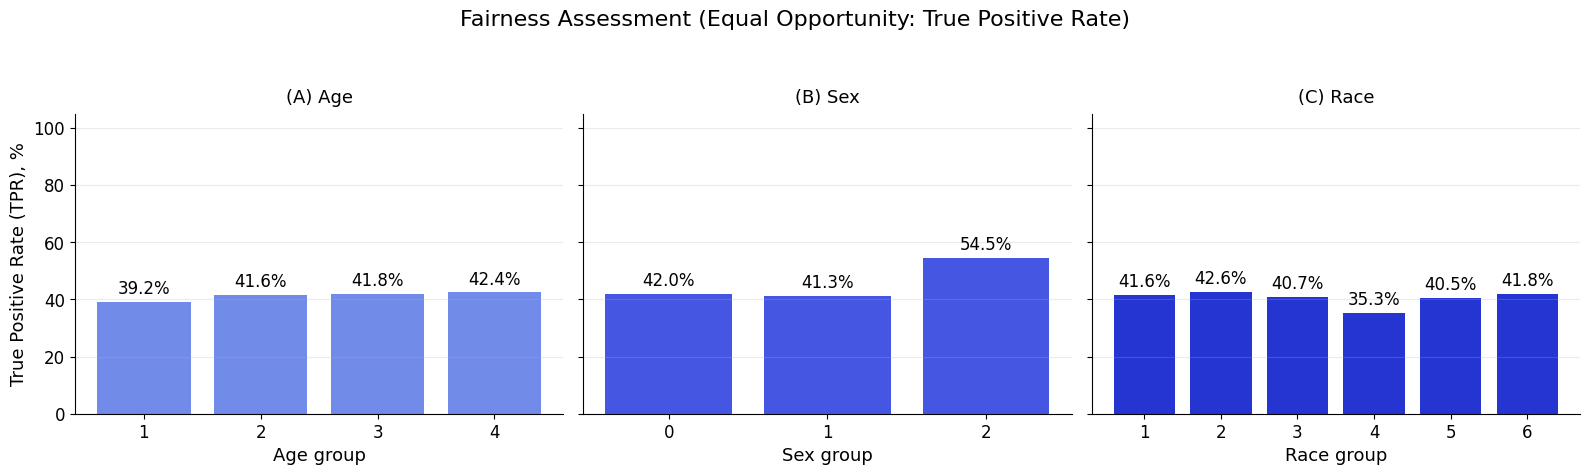

In [49]:
plot_fairness_ijmi(fair_age, fair_sex, fair_race)

In [50]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration_curve(y_true, y_proba, n_bins=10, title="Calibration curve"):
    brier = brier_score_loss(y_true, y_proba)
    frac_pos, mean_pred = calibration_curve(
        y_true, y_proba, n_bins=n_bins, strategy="quantile"
    )

    plt.figure(figsize=(5.2, 5.2))
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Observed fraction of positives")
    plt.title(f"{title}\n(Brier={brier:.4f})")
    plt.tight_layout()
    plt.show()

    return brier


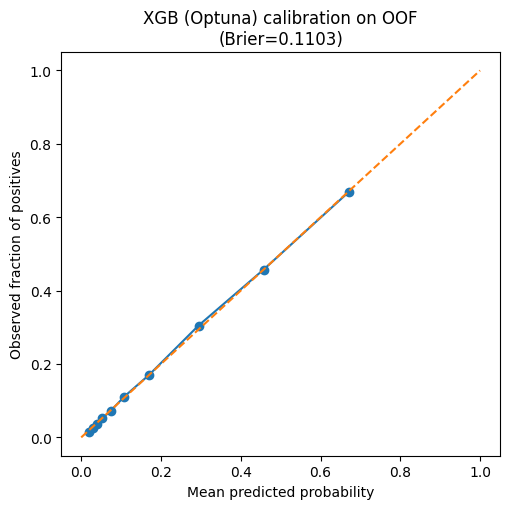

Brier: 0.11032412591707928


In [51]:
brier = plot_calibration_curve(
    xgb_opt_results["y_true_oof"],
    xgb_opt_results["y_proba_oof"],
    n_bins=10,
    title="XGB (Optuna) calibration on OOF"
)

print("Brier:", brier)



In [ ]:
from sklearn.metrics import brier_score_loss
import pandas as pd

brier_rows = []
for name, res in all_results.items():
    y_true  = res["y_true_oof"]
    y_proba = res["y_proba_oof"] 
    brier   = brier_score_loss(y_true, y_proba)

    brier_rows.append({
        "model": name,
        "brier": brier
    })

brier_df = pd.DataFrame(brier_rows).sort_values("brier")
print(brier_df)


            model     brier
1  XGBoost_Optuna  0.110324
0             XGB  0.110973
4        KerasDNN  0.111400
2    RandomForest  0.111681
3             MLP  0.112482
